In [1]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
import os
import gzip
import math
#np.random.seed(42)

In [2]:
#Function to Load images from the file
def load_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28)/ np.float32(256)

In [3]:
#Function to load labels from the file
def load_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

In [4]:
#Function to get images and labels from the corresponding files
def load_data():
    train_images = load_images('train-images-idx3-ubyte.gz')
    train_labels = load_labels('train-labels-idx1-ubyte.gz')
    test_images = load_images('t10k-images-idx3-ubyte.gz')
    test_labels = load_labels('t10k-labels-idx1-ubyte.gz')
    return train_images, train_labels, test_images, test_labels

In [5]:
#Normalize the input data to avoid exploding for sigmoid activation function
def normailize_input(train_images,test_images):
    train_mean = train_images.mean()
    test_mean = test_images.mean()
    train_std = test_images.std()
    test_std = test_images.std()
    train_images = (train_images - train_mean) / train_std
    test_images = (test_images - test_mean) / test_std
    return train_images,test_images

In [6]:
#Function to generate a numpy array for a desired output(one hot encoded)
def get_desired_output(labels):
    D = []
    for label in labels:
        output = np.zeros(10)
        output[label] = 1
        D.append(output)
    return np.array(D)

In [7]:
#Sigmoid activation function for forward propogation
def sigmoid_function(v):
    return 1/(1 + np.exp(-v))

In [8]:
#Derivative of sigmoid activation function for backward propogation
def derv_sigmoid_function(v):
    return sigmoid_function(v) * (1 - sigmoid_function(v))

In [9]:
#Function to generate weights and biases for the network, random uniform distribution
def generate_weights():
    w1 = np.random.uniform(-1,1,(100,784))
    b = np.random.uniform(-1,1,(100,1))
    w2 = np.random.uniform(-1,1,(100,100))
    c = np.random.uniform(-1,1,(100,1))
    w3 = np.random.uniform(-1,1,(10,100))
    d = np.random.uniform(-1,1,(10,1))
    W1 = np.concatenate((b,w1),axis = 1)
    W2 = np.concatenate((c,w2),axis = 1)
    W3 = np.concatenate((d,w3),axis = 1)
    return W1,W2,W3

In [10]:
train_images, train_labels, test_images, test_labels = load_data()
train_images,test_images = normailize_input(train_images,test_images)
D = get_desired_output(train_labels)
D_test = get_desired_output(test_labels)
W1,W2,W3 = generate_weights()
print('Shape of W1: {}'.format(W1.shape))
print('Shape of W2: {}'.format(W2.shape))
print('Shape of W3: {}'.format(W3.shape))

Shape of W1: (100, 785)
Shape of W2: (100, 101)
Shape of W3: (10, 101)


In [11]:
#Function to plot the enery values and misclassifications v/s the number of epochs
def plot(epochs,train_data,test_data,variant,label1,label2):
    fig,ax = plt.subplots(figsize=(8,8))
    train_misclassifications = plt.plot(epochs,train_data,label = label1)
    test_misclassifications = plt.plot(epochs,test_data,label = label2)
    if variant == 'misclassification_plot':
        plt.title('Plot of Number of Misclassifications Vs Number of epochs')
        plt.ylabel('Number of Mis classifications')
    elif variant == 'energy_plot':
        plt.title('Plot of Number of Energy Vs Number of epochs')
        plt.ylabel('Energy values')
    plt.xlabel('Number of epochs')
    ax.legend(loc = 'best')
    plt.show()
    return

In [12]:
#Function to implement forward and backward propogation and find the desired set of weights of the network
def forward_backward_prop(eta,X,X_test,D,D_test,W1,W2,W3):
    epoch = 0
    epochs = []
    errors_train = []
    errors_test = []
    energies_train = []
    energies_test = []
    classification_errors_train = []
    classification_errors_test = []
    while epoch < 200:
        #Training Data
        Y3 = []
        Y3_test = []
        energy_train = 0
        energy_test = 0
        misclassifications = 0
        misclassifications_test = 0
        for i in range(len(X)):
            #first layer
            x = X[i].reshape(784,1)
            unit = np.ones((1,1))
            v1 = np.matmul(W1,np.vstack((unit,x)))
            y1 = sigmoid_function(v1)
            #second_layer
            v2 = np.matmul(W2,np.vstack((unit,y1)))
            y2 = sigmoid_function(v2)
            #output layer
            v3 = np.matmul(W3,np.vstack((unit,y2)))
            y3 = sigmoid_function(v3)
            Y3.append(y3)
            
            #check train misclassifications
            if np.argmax(y3) != np.argmax(D[i]):
                misclassifications+= 1
            #Calculate the train energy using the function provided
            energy_train+= (np.sum(np.subtract(D[i].reshape(10,1),Y3[i])) ** 2) / 2

            #backpropogation
            delta_3 = np.multiply(np.subtract(D[i].reshape(10,1),y3),derv_sigmoid_function(v3))
            delta_2 = np.multiply(np.matmul(W3.transpose(),delta_3)[1:,:],derv_sigmoid_function(v2))
            delta_1 = np.multiply(np.matmul(W2.transpose(),delta_2)[1:,:],derv_sigmoid_function(v1))

            dE_dW1 = np.matmul(-delta_1,np.vstack((unit,x)).transpose())
            dE_dW2 = np.matmul(-delta_2,np.vstack((unit,y1)).transpose())
            dE_dW3 = np.matmul(-delta_3,np.vstack((unit,y2)).transpose())
            
            #update weights
            W1 = W1 + (eta * np.matmul(delta_1,np.vstack((unit,x)).transpose()))
            W2 = W2 + (eta * np.matmul(delta_2,np.vstack((unit,y1)).transpose()))
            W3 = W3 + (eta * np.matmul(delta_3,np.vstack((unit,y2)).transpose()))
        
        energies_train.append(energy_train)
        classification_errors_train.append(misclassifications)
        pct_mis_classifications = misclassifications/len(X)
        pct_accuracy = (len(X) - misclassifications)/len(X)
        print('epoch:',epoch)
        #print('\nTrain - Number of Misclassifications = {}'.format(misclassifications))
        #print('Train - Number of Correct Classfications = {}'.format(len(X) - misclassifications))
        print('Train - Accuracy = {}'.format(pct_accuracy * 100))
        print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications))
        
        #calculate Mean Squared train errror  
        error_train = 0
        for i in range(len(D)):
            error_train+= (np.subtract(D[i].reshape(10,1),Y3[i]) ** 2).mean()
        mse_train = error_train/len(D)
        errors_train.append(mse_train)
        
        #Test Data
        for i in range(len(X_test)):
            x = X_test[i].reshape(784,1)
            unit = np.ones((1,1))
            v1 = np.matmul(W1,np.vstack((unit,x)))
            y1 = sigmoid_function(v1)
            #second_layer
            v2 = np.matmul(W2,np.vstack((unit,y1)))
            y2 = sigmoid_function(v2)
            #output layer
            v3 = np.matmul(W3,np.vstack((unit,y2)))
            y3_test = sigmoid_function(v3)
            Y3_test.append(y3)
        
            #check test misclassifications
            if np.argmax(y3_test) != np.argmax(D_test[i]):
                misclassifications_test+= 1
            
            #Calculate the test energy using the function provided
            energy_test+= (np.sum(np.subtract(D_test[i].reshape(10,1),Y3_test[i])) ** 2) / 2
            
        energies_test.append(energy_test)
        classification_errors_test.append(misclassifications_test)
        pct_mis_classifications_test = misclassifications_test/len(X_test)
        pct_accuracy_test = (len(X_test) - misclassifications_test)/len(X_test)
        print('-' * 50)
        #print('Test - Number of Misclassifications = {}'.format(misclassifications_test))
        #print('Test - Number of Correct Classfications = {}'.format(len(X_test) - misclassifications_test))
        print('Test - Accuracy = {}'.format(pct_accuracy_test * 100))
        print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications_test))
        print('*' * 50)
        
        #calculate test error    
        error_test = 0
        for i in range(len(D_test)):
            error_test+= (np.subtract(D_test[i].reshape(10,1),Y3_test[i]) ** 2).mean()
        mse_test = error_test/len(D_test)
        errors_test.append(mse_test)
        epochs.append(epoch)
        
        #checking for iteration - End the iteration
        if epoch > 0:
            if pct_mis_classifications  <= 0.01 :
                break
            if errors_train[epoch] > errors_train[epoch-1]:
                eta = eta * 0.9
        
        epoch+= 1
    print('epoch:',epoch)
    print('\nTrain - Number of Misclassifications = {}'.format(misclassifications))
    print('Train - Number of Correct Classfications = {}'.format(len(X) - misclassifications))
    print('Train - Accuracy = {}'.format(pct_accuracy * 100))
    print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications))
    print('-' * 50)
    print('Test - Number of Misclassifications = {}'.format(misclassifications_test))
    print('Test - Number of Correct Classfications = {}'.format(len(X_test) - misclassifications_test))
    print('Test - Accuracy = {}'.format(pct_accuracy_test * 100))
    print('Train - Percentage Misclassifications = {}'.format(pct_mis_classifications_test))
    return energies_train,classification_errors_train,errors_train,energies_test,classification_errors_test,errors_test,epochs,W1,W2,W3

In [13]:
eta = 0.1
energies_train,classification_errors_train,mse_errors_train,energies_test,classification_errors_test,mse_errors_test,epochs,W1,W2,W3 = forward_backward_prop(eta,train_images,test_images,D,D_test,W1,W2,W3)

epoch: 0
Train - Accuracy = 86.53166666666667
Train - Percentage Misclassifications = 0.13468333333333332
--------------------------------------------------
Test - Accuracy = 91.31
Train - Percentage Misclassifications = 0.0869
**************************************************
epoch: 1
Train - Accuracy = 93.24333333333334
Train - Percentage Misclassifications = 0.06756666666666666
--------------------------------------------------
Test - Accuracy = 93.83
Train - Percentage Misclassifications = 0.0617
**************************************************
epoch: 2
Train - Accuracy = 94.81833333333334
Train - Percentage Misclassifications = 0.051816666666666664
--------------------------------------------------
Test - Accuracy = 94.0
Train - Percentage Misclassifications = 0.06
**************************************************
epoch: 3
Train - Accuracy = 95.69666666666666
Train - Percentage Misclassifications = 0.04303333333333333
--------------------------------------------------
Test - A

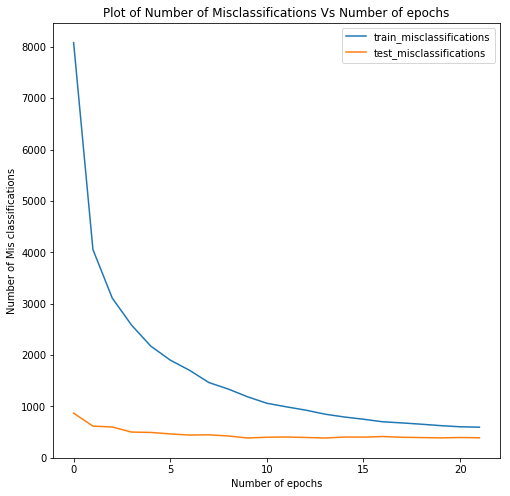

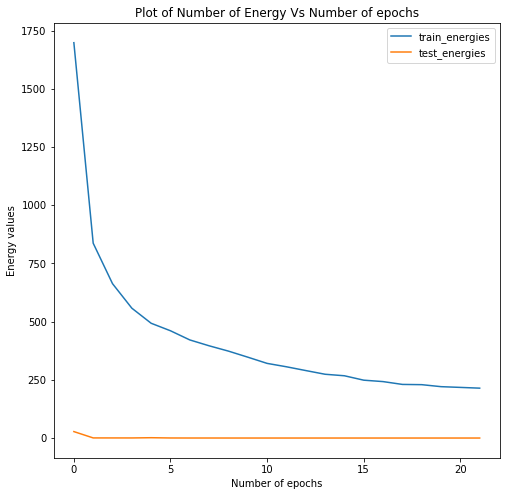

In [14]:
_ = plot(epochs,classification_errors_train,classification_errors_test,'misclassification_plot','train_misclassifications','test_misclassifications')
_ = plot(epochs,energies_train,energies_test,'energy_plot','train_energies','test_energies')